# CIU - Example: Random Forest, Loan Application Classification
This example demonstrates how to use Py-CIU to explain loan application classification decisions as made by a random forest. Let us first create a synthetic dataset of loan applications, with the features and their approval decisions. The dataset has the following features:

* ``age``,
* ``assets``
* ``monthly_income``,
* ``gender_female``,
* ``gender_male``,
* ``gender_other``,
* ``job_type_fixed``,
* ``job_type_none``,
* ``job_type_permanent``.

We import the third-party dependencies, Py-CIU, and a synthetic data generator: 

In [2]:
!pip install -e ../
!pip install sklearn

Obtaining file:///Users/timotheuskampik/Desktop/github/py-ciu
  Found existing installation: py-ciu 0.0.1
    Uninstalling py-ciu-0.0.1:
      Successfully uninstalled py-ciu-0.0.1
  Running setup.py develop for py-ciu


In [3]:
from sklearn.ensemble import RandomForestClassifier

import project_path
from ciu import determine_ciu
from ciu_tests.loan_data_generator import generate_data

Now, we run the generator to create our dataset and use it to create a random forest classifier:

In [4]:
data = generate_data()
train_data = data['train'][1]
test_data = data
test_data_encoded = data['test'][1].drop(['approved'], axis=1)
random_forest = RandomForestClassifier(
    n_estimators=1000,
    random_state=42
)

labels = train_data[['approved']].values.ravel()
data = train_data.drop(['approved'], axis=1)
random_forest.fit(data, labels)



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Now, we take a case and classify it:

In [5]:

feature_names = [
    'age', 'assets', 'monthly_income', 'gender_female', 'gender_male',
    'gender_other', 'job_type_fixed', 'job_type_none', 'job_type_permanent'
]

case = test_data_encoded.values[0]
example_prediction = random_forest.predict([test_data_encoded.values[0]])
example_prediction_prob = random_forest.predict_proba([test_data_encoded.values[0]])
prediction_index = 0 if example_prediction[0] > 0.5 else 1

print(feature_names)
print(f'Case: {case}; Prediction {example_prediction}; Probability: {example_prediction_prob}')



['age', 'assets', 'monthly_income', 'gender_female', 'gender_male', 'gender_other', 'job_type_fixed', 'job_type_none', 'job_type_permanent']
Case: [   35 -9898  8863     1     0     0     0     0     1]; Prediction [False]; Probability: [[0.989 0.011]]


We call the CIU function. Note that this requires use to provide a mapping from "raw data" feature names to one-hot encoded feature names. Also, we want to evaluate the CIU not only of features, but also of the feature interaction *income/assets*.

In [6]:
category_mapping = {
    'gender': ['gender_female', 'gender_male', 'gender_other'],
    'job_type': ['job_type_fixed', 'job_type_none', 'job_type_permanent']
}

feature_interactions = [{'assets_income': ['assets', 'monthly_income']}]

ciu = determine_ciu(
    test_data_encoded.iloc[0, :].to_dict(),
    random_forest.predict_proba,
    {
        'age': [20, 70, True],
        'assets': [-20000, 150000, True],
        'monthly_income': [0, 20000, True],
        'gender_female': [0, 1, True],
        'gender_male': [0, 1, True],
        'gender_other': [0, 1, True],
        'job_type_fixed': [0, 1, True],
        'job_type_none': [0, 1, True],
        'job_type_permanent': [0, 1, True]
    },
    1000,
    prediction_index,
    category_mapping,
    feature_interactions
)


1.0 0.926 1.0 0.077 0.989
0.8513513513513511
0.989 0.135 1.0 0.077 0.989
1.0
1.0 0.945 1.0 0.077 0.989
0.8
0.989 0.981 1.0 0.077 0.989
1.0
0.989 0.965 1.0 0.077 0.989
1.0


Finally, we display the contextual importance (importance for class) and utility (typicality for class) in different ways:

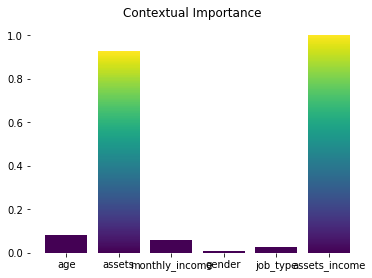

In [7]:
ciu.plot_ci()

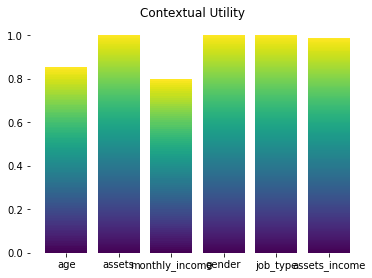

In [8]:
ciu.plot_cu()

In [8]:
print(ciu.text_explain())

['The feature "age", which is very important (CI=70.65%), is typical for its class (CU=58.62%).', 'The feature "assets", which is very important (CI=68.77%), is not typical for its class (CU=15.62%).', 'The feature "monthly_income", which is highly important (CI=79.84%), is unlikely for its class (CU=29.96%).', 'The feature "gender", which is not important (CI=7.42%), is very typical for its class (CU=100.0%).', 'The feature "job_type", which is not important (CI=5.09%), is not typical for its class (CU=0.1%).', 'The feature "assets_income", which is highly important (CI=83.39%), is unlikely for its class (CU=29.75%).', 'The feature "assets_income", which is highly important (CI=83.39%), is unlikely for its class (CU=29.75%).']
